In [7]:
# This version of the SVD fits using states expressed as excitations relative to a nuclear ground state
# RMS error for this fit looks to be a match with e35 produced by BAB
import random
import math
import scipy.linalg

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from numpy.linalg import inv
from scipy import stats
from IPython.display import Image

# Read output-energy file as fixed-width file (fwf) into dataframe object, columns aren't labeled with a header
energyDF = pd.read_csv('xfit.dat', header=None, delim_whitespace=True).to_numpy()
dataIn = pd.read_fwf('exp.dai', header=None, delim_whitespace=True).to_numpy()
nuclei = dataIn[:,6]

# extract the SPEs and TBME's for the background (n50em) interaction
backgroundHam = energyDF[0,5:75]      # First 5 terms are not Hamiltonian parameters and can be dropped

# do the same for the fitted interaction from BAB
fittedHam = energyDF[1,5:75]

# extract experimental energies and experimental errors from dataframe
exp = energyDF[2:,1]
expAbs = energyDF[2:,2]
error = energyDF[2:,3]
#print(exp)

# extract matrix of beta coefficients for calculating absolute energies of each state
betasAbs = energyDF[2:,5:]

# extract a matrix of the beta coefficients in each energy contribution for the Hamiltonian in terms of excited states
betas = np.empty([len(exp),len(backgroundHam)])
for i in range(len(exp)):
    for j in range(len(backgroundHam)):
        if exp[i] <= 0:
            betas[i,j] = energyDF[i+2,j+5]
            gsContributions = betas[i,:]
        else:
            betas[i,j] = energyDF[i+2,j+5] - gsContributions[j]

C:\Users\purcell\AppData\Local\Temp/ipykernel_16844/675573870.py:87: RuntimeWarning: invalid value encountered in double_scalars
  eRMSRangeTest[b,i] = scipy.linalg.norm(eResidualTest)/math.sqrt(len(eResidualTest))


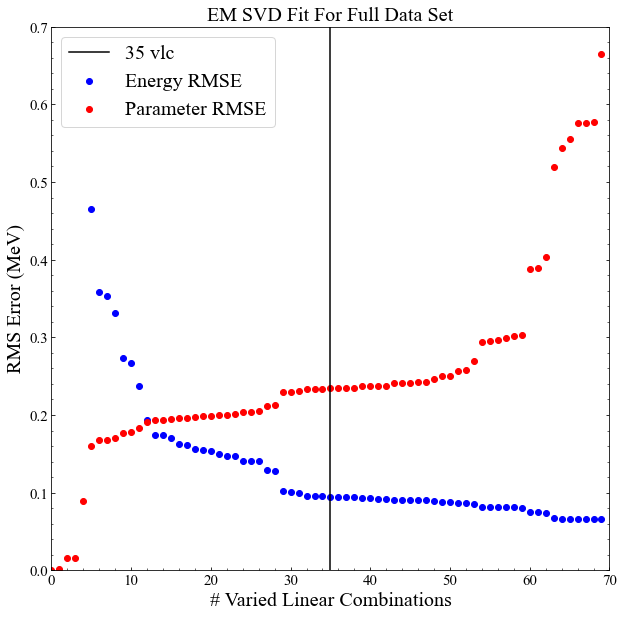

In [12]:
# This segment iterates (numBatches times) over randomized batches of the available data (including all ground states)
# All excited states from 79Cu to 99In are available for building training batches
# The full dataset is used for testing

numBatches = 1
eRMSRangeAll = np.empty([numBatches,len(backgroundHam)+1])
eRMSRangeTest = np.empty([numBatches,len(backgroundHam)+1])
eRMSRangeTrain = np.empty([numBatches,len(backgroundHam)+1])
pRMSRange = np.empty([numBatches, len(backgroundHam)+1])
dataPercent = 1.0               # percent of the dataset to include in the testing sets

for b in range(numBatches):
    # Select a random batch of data to fit the parameters to (making sure that ground states are always included in the batch)
    batchChoice = np.zeros(len(exp))
    random.seed()
    for i in range(len(exp)):
        if exp[i] <= 0.0:
            batchChoice[i] = 1
        else:
            k = random.random()
            if k >= 1-dataPercent:
                batchChoice[i] = 1

    batchExp = np.empty(int(np.sum(batchChoice)))
    batchError = np.empty(len(batchExp))
    batchBetas = np.empty([len(batchExp), len(backgroundHam)])
    batchIndex = 0
    for i in range(len(exp)):
        if batchChoice[i] == 1:
            batchExp[batchIndex] = exp[i]
            batchError[batchIndex] = error[i]
            batchBetas[batchIndex] = betas[i]
            batchIndex += 1
                    
    # Finally we construct our design matrix (G), initial parameter vector (pInit), and data vector (e) for fitting
    e = np.empty(len(backgroundHam))
    G = np.empty((len(backgroundHam),len(backgroundHam)))
    for i in range(len(backgroundHam)):           # Contructing data vector (e)
        eTot = 0
        for k in range(len(batchExp)):
            eTot += (batchExp[k]*batchBetas[k,i])/(batchError[k]**2)
        e[i] = eTot
    for i in range(len(backgroundHam)):           # Constructing design matrix (G)
        for j in range(len(backgroundHam)):
            gTot = 0
            for k in range(len(batchExp)):
                gTot += (batchBetas[k,i]*batchBetas[k,j])/(batchError[k]**2)
            G[i,j] = gTot

    # Here we perform an SVD of our design matrix and invert the singular values (in S)
    # to create linear combinations of our parameters in p for our successive fits, iterating over the singular values
    U, Svec, Ut = np.linalg.svd(G)
    # Now we apply our minimization (e = Gp) by using our SVD matrices U,S, and Ut to rotate
    # e and p into new vectors c and y, respectively
    c = np.dot(Ut,e)
    y = np.dot(Ut,backgroundHam)

    # This is where we iteratively vary the linear combinations of parameters by selecting the increasing values in Sinv
    # at the end we will apply fitted weights p to our initial parameters to calculate their RMS and energy RMS
    pRMS = np.empty(len(Svec)+1)                  # The +1 is to include the unfitted case where we vary 0 linear combinations
    fitEnergies = np.empty(len(exp))              # Array for storing fitted energies resulting from the chosen #VLC fit
    numVLC = 35                                   # Number of VLC to choose for the output Hamiltonian
    for i in range(len(backgroundHam)+1):
        yfit = np.empty(len(backgroundHam))
        fitParameters = np.empty(len(backgroundHam))               # Array for storing fitted parameters in this iteration
        eResidualAll = np.empty(0)                             # Array for storing residuals for RMS calculation
        eResidualTest = np.empty(0)
        eResidualTrain = np.empty(0)
        for j in range(len(backgroundHam)):
            if j < i:                             # Modify our linear combinations in y = U^Tp by our data in c = U^Te
                yfit[j] = c[j]/Svec[j]
            elif j >= i:                           # Keep the original linear combinations y = U^Tp from starting Hamiltonian
                yfit[j] = y[j]
        fitParameters = np.dot(U,yfit)                      # Rotate back to our fitted p vector through p = Uy
        for j in range(len(exp)):
            eFitTot = 0
            for k in range(len(backgroundHam)):
                eFitTot += fitParameters[k]*betas[j,k]                # Modify our initial energy contributions to state j by new weights
            if error[j] <= 1.0:
                eResidualAll = np.append(eResidualAll, exp[j]-eFitTot)
                if batchChoice[j] == 0:
                    eResidualTest = np.append(eResidualTest, exp[j]-eFitTot)
                elif batchChoice[j] ==1:
                    eResidualTrain = np.append(eResidualTrain, exp[j]-eFitTot)
        pResidual = backgroundHam - fitParameters
        eRMSRangeAll[b,i] = scipy.linalg.norm(eResidualAll)/math.sqrt(len(eResidualAll))
        eRMSRangeTest[b,i] = scipy.linalg.norm(eResidualTest)/math.sqrt(len(eResidualTest))
        eRMSRangeTrain[b,i] = scipy.linalg.norm(eResidualTrain)/math.sqrt(len(eResidualTrain))
        pRMSRange[b,i] = scipy.linalg.norm(pResidual)/math.sqrt(len(pResidual))
        if i == numVLC:
            outputHam = fitParameters

# For a given number of singular values, calculate the averave RMSE across batches
eRMSaverageAll = np.empty(len(pRMS))
eRMSaverageTest = np.empty(len(pRMS))
eRMSaverageTrain = np.empty(len(pRMS))
pRMSaverage = np.empty(len(pRMS))
for i in range(len(pRMS)):
    eRMSaverageAll[i] = np.sum(eRMSRangeAll[:,i])/numBatches
    eRMSaverageTest[i] = np.sum(eRMSRangeTest[:,i])/numBatches
    eRMSaverageTrain[i] = np.sum(eRMSRangeTrain[:,i])/numBatches
    pRMSaverage[i] = np.sum(pRMSRange[:,i])/numBatches

#print('35 vlc eRMS (average) =', eRMSaverageAll[34], ' pRMS (average) = ', pRMSaverage[34])
#print('full SVD eRMS =', eRMSaverageAll[69], ' pRMS =', pRMSaverage[69])
#print('BAB parameter RMS = ', scipy.linalg.norm(backgroundHam-fittedHam)/math.sqrt(len(backgroundHam)))

x = [i for i in range(len(pRMS))] 
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
alphaValue = 1
for i in range(numBatches):
    plt.scatter(x, eRMSRangeAll[i], label='Energy RMSE', color='b', alpha=alphaValue)
    #plt.scatter(x, eRMSRangeTest[i], color='g', alpha=alphaValue)
    #plt.scatter(x, eRMSRangeTrain[i], color='m', alpha=alphaValue)
    plt.scatter(x, pRMSRange[i], label='Parameter RMSE', color='r', alpha=alphaValue)
#plt.plot(x, eRMSaverageAll, label='Energy RMS (all data)', color='b')
#plt.plot(x, eRMSaverageTest, label='Energy RMS (test data)', color='g')
#plt.plot(x, eRMSaverageTrain, label='Energy RMS (train data)', color='m')
#plt.plot(x, pRMSaverage, label='parameter RMS', color='r')
plt.axvline(x = numVLC, color = 'k', label = '%i vlc' %numVLC)
plt.xlabel('# Varied Linear Combinations')
plt.ylabel('RMS Error (MeV)')
#plt.title('EM SVD Fit For %i Batches of Full Data Set' %numBatches, fontsize=20)
plt.title('EM SVD Fit For Full Data Set', fontsize=20)
plt.axis([0,70,0.0,0.7])
plt.minorticks_on()
plt.tick_params(which="both", direction="in", right=True)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=20).set_alpha(1)
plt.legend(loc='upper left',fontsize=20).set_alpha(1)
plt.show()

In [5]:
# Here we perform an SVD of our design matrix and invert the singular values (in S)
# to create linear combinations of our parameters in p for our successive fits, iterating over the singular values
U, Svec, Ut = np.linalg.svd(G)
# Now we apply our minimization (e = Gp) by using our SVD matrices U,S, and Ut to rotate
# e and p into new vectors c and y, respectively
c = np.dot(Ut,e)
y = np.dot(Ut,pInit)

35 vlc eRMS = 0.10218310692471827  pRMS =  0.27657582438014633
full SVD eRMS = 0.06917679683721369  pRMS = 0.6155229416263579


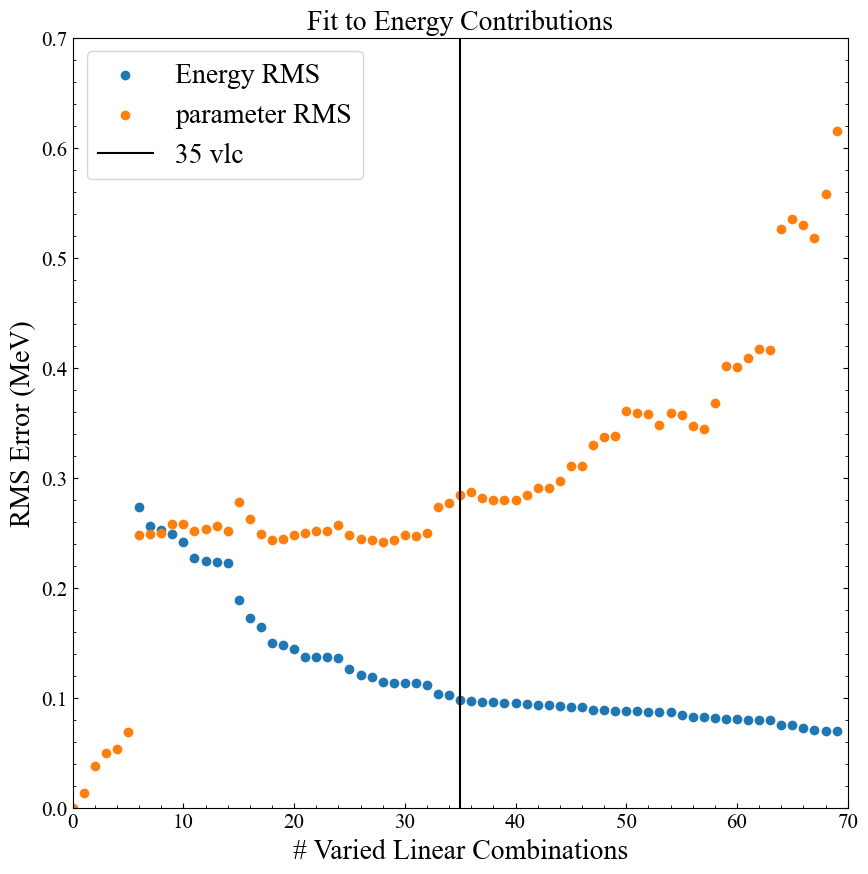

In [6]:
# This is where we iteratively vary the linear combinations of parameters by selecting the increasing values in Sinv
# at the end we will apply fitted weights p to our initial parameters to calculate their RMS and energy RMS
eRMS = np.empty(len(Svec)+1)                  # The +1 is to include the unfitted case where we vary 0 linear combinations
pRMS = np.empty(len(Svec)+1)
for i in range(len(backgroundHam)+1):
    yfit = np.zeros(len(backgroundHam))
    fitParameters = np.empty(len(backgroundHam))               # Array for storing fitted parameters in this iteration
    fitEnergies = np.empty(len(exp))                    # Array for storing fitted energies in this iteration
    eResidual = np.empty(0)
    for j in range(len(backgroundHam)):
        if j < i:                             # Modify our linear combinations in y = U^Tp by our data in c = U^Te
            yfit[j] = c[j]/Svec[j]
        elif j >= i:                           # Keep the original linear combinations y = U^Tp from starting Hamiltonian
            yfit[j] = y[j]
    pfit = np.dot(U,yfit)                      # Rotate back to our fitted p vector through p = Uy
    for j in range(len(backgroundHam)):       
        fitParameters[j] = pfit[j]*backgroundHam[j] # Modify our initial fit parameters by the new weights in pfit
    for j in range(len(exp)):
        eFitTot = 0
        for k in range(len(backgroundHam)):
            eFitTot += pfit[k]*E[j,k]                # Modify our initial energy contributions to state j by new weights
        fitEnergies[j] = eFitTot
        if error[j] <= 1.0:
            eResidual = np.append(eResidual, exp[j]-eFitTot)
    pResidual = backgroundHam - fitParameters
    eRMS[i] = scipy.linalg.norm(eResidual)/math.sqrt(len(eResidual))
    pRMS[i] = scipy.linalg.norm(pResidual)/math.sqrt(len(pResidual))
print('35 vlc eRMS =', eRMS[34], ' pRMS = ', pRMS[34])
print('full SVD eRMS =', eRMS[69], ' pRMS =', pRMS[69])
x = [i for i in range(len(eRMS))]
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.scatter(x, eRMS, label='Energy RMS')
plt.scatter(x, pRMS, label='parameter RMS')
plt.axvline(x = 35, color = 'k', label = '35 vlc')
plt.xlabel('# Varied Linear Combinations')
plt.ylabel('RMS Error (MeV)')
plt.title('Fit to Energy Contributions',fontsize=20)
plt.axis([0,70,0.0,0.7])
plt.minorticks_on()
plt.tick_params(which="both", direction="in", right=True)
plt.legend(loc=2,fontsize=20)
plt.show()

In [7]:
# Fit using a handwritten least-squares solution to the minimization problem
Ginv = inv(G)
pfinal = np.dot(Ginv,e)
newHam = np.empty(len(backgroundHam))
for i in range(len(newHam)):
    newHam[i] = pfinal[i]*backgroundHam[i]
pRes = newHam-backgroundHam
eRes = np.empty(0)
for j in range(len(exp)):
        if error[j] <= 1.0:
            eFitTot = 0
            for k in range(len(backgroundHam)):
                eFitTot += pfit[k]*E[j,k]                # Modify our initial energy contributions to state j by new weights
            eRes = np.append(eRes, eFitTot - exp[j])
print('least squares energy RMS =', scipy.linalg.norm(eRes)/math.sqrt(len(eRes)))
print('least squares parameter RMS =', scipy.linalg.norm(pRes)/math.sqrt(len(pRes)))

least squares energy RMS = 0.06917679683721369
least squares parameter RMS = 0.6155229437275077


In [8]:
# Least squares solution using numpy linalg as a check that my least squares solution agrees
newExp = np.empty(len(exp))
M = np.empty([len(exp),len(backgroundHam)])
for i in range(len(exp)):
    newExp[i] = exp[i]/error[i]
    for j in range(len(backgroundHam)):
        M[i,j] = E[i,j]/error[i]
lstSq = np.linalg.lstsq(M, newExp, rcond=None)

#print(lstSq[0])                    # This is the set of weights which minimizes least squares for the energy contributions
lsEnergy = np.empty(len(exp))
eRes = np.empty(0)
for j in range(len(exp)):
        if error[j] <= 1.0:
            eFitTot = 0
            for k in range(len(backgroundHam)):
                eFitTot += lstSq[0][k]*E[j,k]                # Modify our initial energy contributions to state j by new weights
            eRes = np.append(eRes, exp[j]-eFitTot)
print('least squares energy RMS =', scipy.linalg.norm(eRes)/math.sqrt(len(eRes)))

lsHam = np.empty(len(backgroundHam))
for i in range(len(lsHam)):
    lsHam[i] = lstSq[0][i]*backgroundHam[i]
pRes = lsHam-backgroundHam
print('least squares parameter RMS =', scipy.linalg.norm(pRes)/math.sqrt(len(pRes)))
print(lsHam-fittedHam)                                  # Difference between BAB Hamiltonian and my least squares

least squares energy RMS = 0.06917679683931953
least squares parameter RMS = 0.6155229394987632
[-1.01391758e-01 -1.09238978e-02  4.86835578e-02 -1.19854953e-01
  1.16848535e-02 -2.83257304e-01  5.24890008e-03 -5.76026477e-01
  6.67407822e-02 -4.83594548e-01 -7.75080494e-01 -2.87143589e-02
 -9.53845512e-02 -7.14456350e-01 -7.67062782e-01 -8.78720670e-01
 -2.41352820e-01 -1.92384246e-01  2.44720038e-01 -5.34510628e-02
 -9.16079477e-01  9.18716252e-01 -8.11477088e-01 -2.75405397e-02
 -2.83998993e-01  8.61601834e-01 -9.01528955e-01  1.59058196e-01
 -3.04547114e-01  9.59627638e-01 -5.27431866e-01 -4.66722432e-01
  7.02268927e-01 -4.26288858e-02 -3.49308934e-01 -2.13888748e-01
  3.43073480e-02  5.04816917e-01 -2.81547678e-01  4.29141432e-01
  7.02824904e-01  2.05073179e-01 -4.53290513e-01  5.22099806e-01
  7.16004358e-02  2.29259546e-03  4.29043545e-01 -2.88727765e+00
  4.36484639e-02 -7.58711343e-01 -4.02819177e-01  3.90048473e-01
  3.82452439e-01 -1.02389606e-01  7.22306791e-02  8.9178978